In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import shutil
import time
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set_style('darkgrid')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
dir = r'/kaggle/input/lung-and-colon-data' 

file_paths = []
labels = []

for root, dirs, files in os.walk(dir):
    for classs in dirs:
        if classs in ["lung_image_sets", "colon_image_sets"]:
            continue  
        class_path = os.path.join(root, classs)
        flist = os.listdir(class_path)
        for f in flist:
            fpath = os.path.join(class_path, f)
            file_paths.append(fpath)
            labels.append(classs)

Fseries = pd.Series(file_paths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis=1)
df = data_df.reset_index(drop=True)  

print(df['labels'].value_counts())

In [ ]:
sample_size = 5000 
sample_list = []
group = df.groupby('labels')
for label in df['labels'].unique():    
    label_group = group.get_group(label).sample(sample_size, 
                                                replace=False, 
                                                random_state=42, 
                                                axis=0)
    sample_list.append(label_group)
df = pd.concat(sample_list, axis=0).reset_index(drop=True)
print(f"Total after sampling: {len(df)}")

In [ ]:
train_split = 0.8
test_split = 0.1
val_split = 1 - (train_split + test_split)

train_df, remaining_df = train_test_split(df, 
                                          train_size=train_split, 
                                          shuffle=True, 
                                          random_state=42)
test_df, valid_df = train_test_split(remaining_df, 
                                     train_size=test_split / (test_split + val_split), 
                                     shuffle=True, 
                                     random_state=42)

print(f"train_df: {len(train_df)}, test_df: {len(test_df)}, valid_df: {len(valid_df)}")

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

In [ ]:
height = 224
width = 224
channels = 3
batch_size = 32
img_size = (height, width)

In [ ]:
transform = Compose([
    Resize(img_size),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.filepaths = dataframe['filepaths'].values
        self.labels = LabelEncoder().fit_transform(dataframe['labels'].values)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        file_path = self.filepaths[idx]
        label = self.labels[idx]
        image = Image.open(file_path).convert("RGB")
        image = transform(image)
        return image, label


In [ ]:
length = len(test_df)
test_batch_size = max([
    int(length / n) 
    for n in range(1, length + 1) 
    if length % n == 0 and length / n <= 80
])
test_steps = length // test_batch_size
print('Test batch size:', test_batch_size, 'Test steps:', test_steps)

In [ ]:
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)
valid_dataset = CustomDataset(valid_df)

In [ ]:
pin_mem = True if device.type == 'cuda' else False


In [ ]:
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=4,
                          pin_memory=pin_mem)

test_loader = DataLoader(test_dataset, 
                         batch_size=test_batch_size, 
                         shuffle=False, 
                         num_workers=4,
                         pin_memory=pin_mem)

valid_loader = DataLoader(valid_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=4,
                          pin_memory=pin_mem)


In [ ]:
classes = train_df['labels'].unique().tolist()
class_count = len(classes)
print(f"Found {len(train_dataset)} images for training belonging to {class_count} classes")
print(f"Found {len(test_dataset)} images for testing belonging to {class_count} classes")
print(f"Found {len(valid_dataset)} images for validating belonging to {class_count} classes")

In [ ]:
def display_image(loader, classes):
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    
    images_np = images.cpu().numpy()
    labels_np = labels.cpu().numpy()

    plt.figure(figsize=(20, 20))
    r = min(len(labels_np), 15)

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images_np[i].transpose(1, 2, 0) * 0.5) + 0.5
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        class_name = classes[labels_np[i]]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [ ]:
display_image(train_loader,classes)


In [ ]:
display_image(test_loader,classes)


In [ ]:
display_image(valid_loader,classes)


## **Vision Transformers implementation**

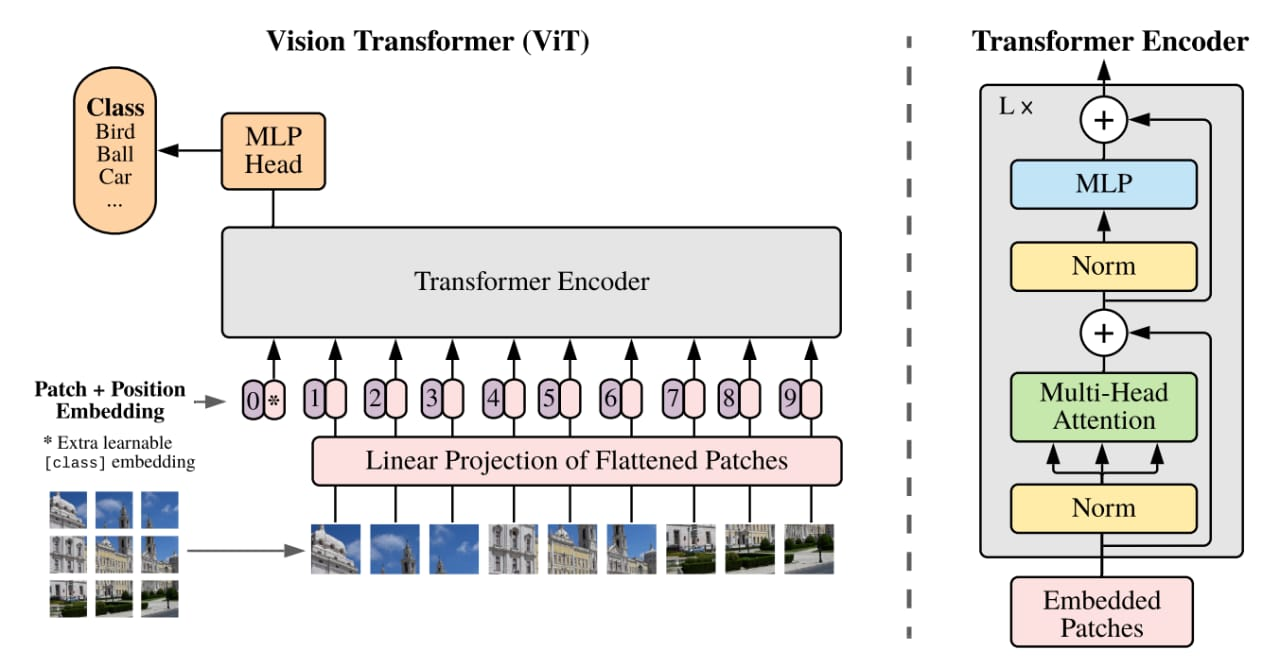
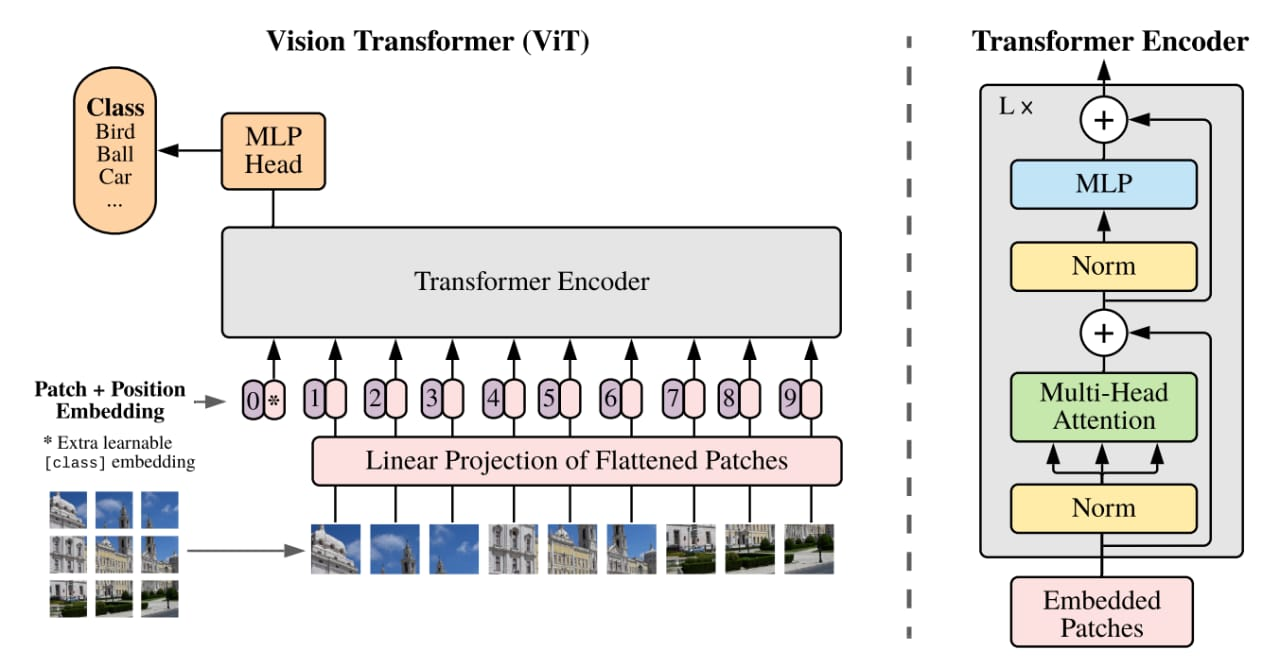

In [ ]:
class patchembedding(nn.Module):
    def __init__(self,in_channels=3,patch_size=16,embedding_dim=768,img_size=224):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size//patch_size)*(img_size//patch_size)
        self.projection = nn.Conv2d(
            in_channels,
            embedding_dim,
            kernel_size = patch_size,
            stride = patch_size
        )

    def forward(self,x):
        x = self.projection(x)  # (B, 3, H, W)
        x = x.flatten(2) # (B, emb_size, num_patches)
        x = x.transpose(1,2)
        return x

In [ ]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [ ]:
class multihead_selfattention(nn.Module):
    def __init__(self,embedding_dim=768,num_heads=8,dropout=0.1):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim//num_heads

        self.qkv = nn.Linear(embedding_dim,3*embedding_dim)
        self.o = nn.Linear(embedding_dim,embedding_dim)
        self.dropout = nn.Dropout(dropout)


    def forward(self,x):
        B,N,C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(B,N,3,self.num_heads,self.head_dim)
        qkv = qkv.permute(2,0,3,1,4)
        q,k,v = qkv[0],qkv[1],qkv[2]

        attention_score = (q@k.transpose(-2,-1))/(self.head_dim**0.5)
        attention = attention_score.softmax(dim=-1)
        attention = self.dropout(attention)

        output = attention@v
        output = output.transpose(1,2).reshape(B,N,C)
        output = self.o(output)
        return output

In [ ]:
class transformer_encoder(nn.Module):
    def __init__(self,embedding_dim=768,num_heads=8,expansion=4,dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.attention = multihead_selfattention(embedding_dim,num_heads,dropout)

        self.norm2 = nn.LayerNorm(embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim,expansion*embedding_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(expansion*embedding_dim,embedding_dim),
            nn.Dropout(dropout)
        )

    def forward(self,x):
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=5,
                embedding_dim=768, depth=8, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.patch_embed = patchembedding(in_channels, patch_size, embedding_dim, img_size)
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.cls = nn.Parameter(torch.zeros(1, 1, embedding_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embedding_dim))
        self.pos_drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList(
            [transformer_encoder(embedding_dim, num_heads, expansion=int(mlp_ratio), dropout=dropout) 
            for _ in range(depth)]
        )
        self.norm = nn.LayerNorm(embedding_dim)
        self.fc = nn.Linear(embedding_dim, num_classes)  # Changed from 'full' to 'fc'
        self.init_weights()

    def init_weights(self):
        nn.init.normal_(self.cls, std=1e-6)
        nn.init.normal_(self.pos_embed, std=1e-6)
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.LayerNorm): 
                nn.init.constant_(module.weight, 1.0)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls = self.cls.repeat(B, 1, 1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed[:, :x.size(1), :]
        x = self.pos_drop(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)[:, 0]
        x = self.fc(x)
        return x

In [ ]:
model = ViT(
    img_size=height,
    patch_size=16,
    in_channels=3,
    num_classes=class_count,
    embedding_dim=384,
    depth=6,
    num_heads=6,
    mlp_ratio=4.0,
    dropout=0.1
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
model_path = "/kaggle/working/best_vit_model.pth"

epochs = 20  
best_val_acc = 0.0

# Train loop
for epoch in range(1, epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, valid_loader, criterion, device)

    print(f"Epoch [{epoch}/{epochs}] "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}")
    
    # Save only the best model in Kaggle working directory
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}!")

In [ ]:
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
clr = classification_report(all_labels, all_preds, target_names=classes)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", clr)

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Vision Transformer")
plt.show()